
### <center>Goal</center>
This notebook aims to predict hotel Cancellations.

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dl-course-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F829369%2F1480608%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241001%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241001T124332Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5f0b90e3cc1c55b4f07ef10f08a4d8da185fba17c5cc566f5e1ac1b4cdb60e63a6d98d6a844a40e85b5266618add13814f85cd6e6e98c31225a4811f0a455596521a10d46363be8544d0b3beac0415efa38ded200559c0113d07a16a9ec7cabbc0331237c215f730d8788be51c43ac2cc2943a095650d54595ab7b357a0987d03ea093d61fa1a6659d6ee7e0d0f411cec390838087de088144c313c14fd53b3e0c94d4a2f8d4cb9c317aaf832f5657f209a536dcb342f344c272e5ce7092bde9948fd5bd383430243fa2e47c6c0f77772a00cc8b056dc74b20ca9d34ecdd6d4c69d30c0a06fc2f3f66a45aeb39e639084b2f1569d357d6400117babb8a51ac31'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 242157006 bytes downloaded
Downloaded and uncompressed: dl-course-data
Data source import complete.


### Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Reading Dataset

In [81]:
df = pd.read_csv('../input/dl-course-data/hotel.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Dataset Information

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
len(df.columns)

32

- Checking number of null values

In [ ]:
df.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


- Total number of null values:

In [ ]:
df.isnull().sum().sum()

129425

- Since company and agent have the highest number of null values and they only represent respectively the ID of the company or the travel agent who did the booking, I'll drop them.
- I'll see wether to keep country and replace the null values with the mean based on the visualization part.

In [82]:
df.drop(['company', 'agent'],axis=1,inplace=True)

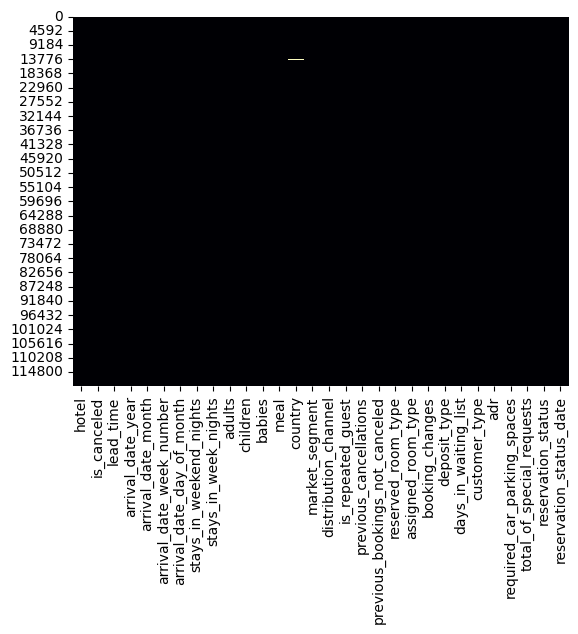

In [ ]:
sns.heatmap(df.isnull(),cmap = 'magma',cbar = False);


In [69]:
categorical_features = []
numerical_features = []

# Loop through each column and classify based on data type
for column in df.columns:
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        numerical_features.append(column)
    else:
        categorical_features.append(column)

- Determine categorical and numerical columns

In [ ]:
df.describe().T # For numerical columns

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


- For columns babies and children, it has a max of 10 for one room booking wich might seem weird. It could be noise so I' ll probably delete it. Same thing for adult that has a min of 0 which means that a book was booked with no adult in it and it doesn' t make sense.
- Adr which the average daily rate has a negative mean which doesn't make sense at all.
- Some features like required_car_parking_spaces has a zero std, 25%, 50% and even 75% so this means that is has little to no  variability. It's nearly constant. These often provide little to no predictive power for a model but before deciding to drop it we need to consider the fewer cases that are different and their relation with the target variable.


- Statistical summary for categorical features:

In [59]:
df.describe(include = 'object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,118902,177,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
reserved_room_type,119390,10,A,85994
assigned_room_type,119390,12,A,74053
deposit_type,119390,3,No Deposit,104641
customer_type,119390,4,Transient,89613


### Visualization

#### Target

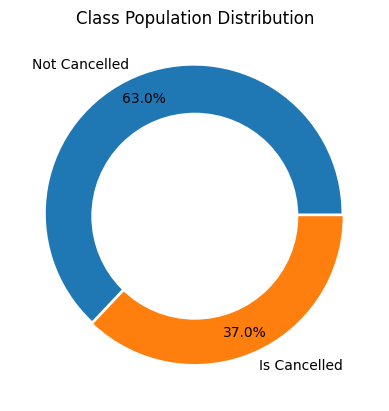

In [ ]:
# Map targets to meaningful statements
classes = {
    'Not Cancelled': 0,
    'Is Cancelled': 1
}
# Find the number of cancellations
class_pop = [len(df[df['is_canceled'] == _class]) for _class in classes.values()]
# Drawing a donut chart
plt.title('Class Population Distribution')
plt.pie(
    x=class_pop,
    labels=classes.keys(),
    autopct='%.1f%%',
    explode=[0.02, 0],
    pctdistance=0.85
)
center_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.savefig('Class Population.jpg', dpi=300)
plt.show()

- The Dataset is not that balanced. We' ll see next if we need sampling techniques.
- The majority of rooms are not cancelled

#### lead_time
lead_time represents the number of days between booking and arrival to the hotel

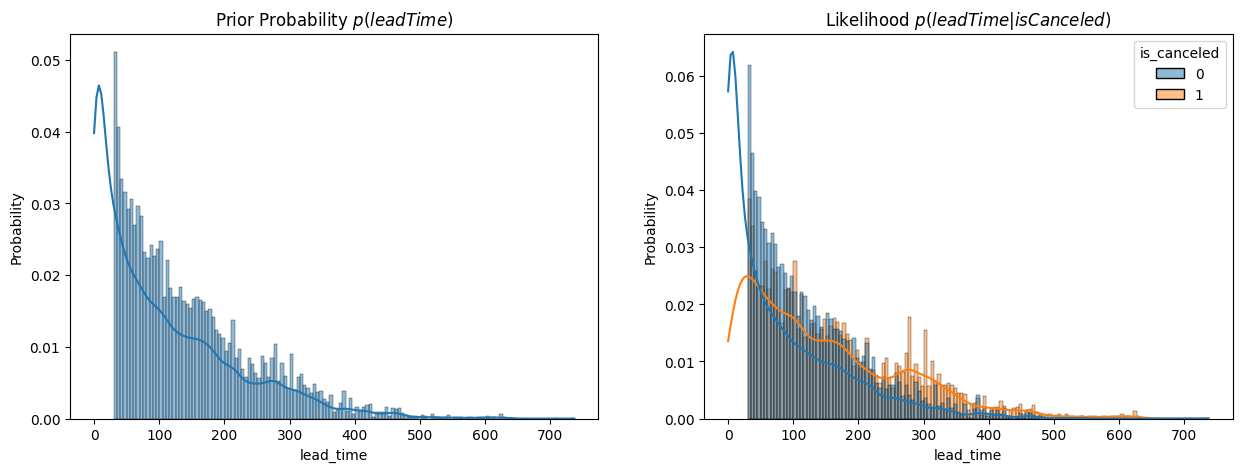

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Prior Probability $p(leadTime)$')
sns.histplot(
    data=df, x='lead_time',
    kde=True,
    binwidth=5, binrange=(30, df['lead_time'].max()),
    stat='probability', common_norm=False,
    ax=axes[0]
)
plt.subplot(1, 2, 2)
plt.title(r'Likelihood $p(leadTime|isCanceled)$')
sns.histplot(
    data=df, x='lead_time',
    kde=True,
    binwidth=5, binrange=(30, df['lead_time'].max()),
    hue='is_canceled',
    stat='probability', common_norm=False,
    ax=axes[1]
)
plt.savefig('lead_time.jpg', dpi=300)
plt.show()


- Majority of people who book their hotel rooms few days before the check in.However, there is a visible tail that extends far beyond 300 days. This tail represents a smaller proportion of total bookings, but it does confirm that some guests do book their stays significantly in advance.
- people who book their rooms in advance are more likely to cancel their reservations starting from a lead time of 100 days.
- Most non-canceled bookings have short lead times.



#### customer_type
Type of customer (Transient, Contract, Transient-Party, Group)

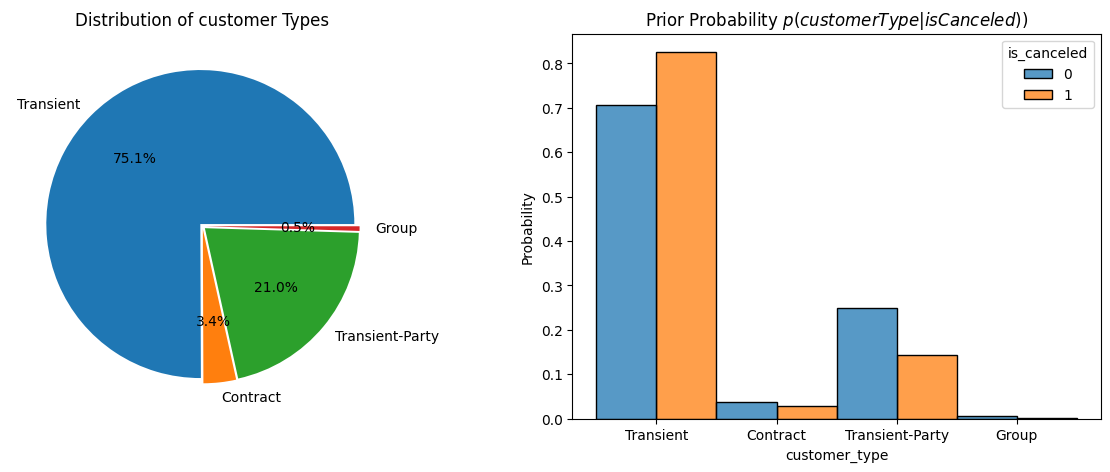

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)

classes = df['customer_type'].unique()
classespop = [len(df[df['customer_type'] == _class ]) for _class in classes]
plt.title('Distribution of customer Types')
plt.pie(
    x=classespop ,
    labels=classes,
    autopct='%.1f%%',
    explode=0.02 * np.ones(len(classes))
)

plt.subplot(1, 2, 2)
plt.title('Prior Probability $p(customerType|isCanceled))$')
sns.histplot(
    data=df, x='customer_type',
    hue = 'is_canceled',
    stat='probability', common_norm=False,
    multiple= 'dodge',
    ax=axes[1]
)


plt.savefig('customer_type.jpg', dpi=300)
plt.show()


- Transient: Individual travelers booking for leisure or business purposes.
- Contract: Bookings made under a contract, such as corporate clients or for airline crews.
- Transient-Party: A form of transient booking but involving a party, such as families or friends booking together.
- Group: Bookings made for large groups under a single reservation, typically for events or conferences.

- The majority of bookings are from Transient or transient-party.
- Transient customers are more likely to cancel their reservations unlike transient-Party. Regarding contract customer, the probability to cancel is lower than the probabilty to not cancel, likely due to the nature of their commitments and agreements.

#### reserved_room_type

Type of reserved room

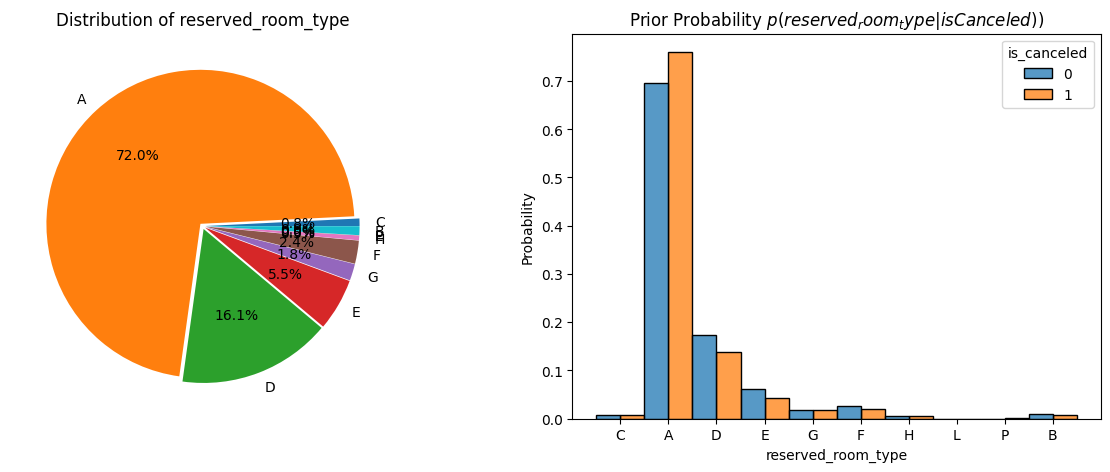

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)

classes = df['reserved_room_type'].unique()
classespop = [len(df[df['reserved_room_type'] == _class ]) for _class in classes]
plt.title('Distribution of reserved_room_type')
plt.pie(
    x=classespop ,
    labels=classes,
    autopct='%.1f%%',
    explode=0.02 * np.ones(len(classes))
)

plt.subplot(1, 2, 2)
plt.title('Prior Probability $p(reserved_room_type|isCanceled))$')
sns.histplot(
    data=df, x='reserved_room_type',
    hue = 'is_canceled',
    stat='probability', common_norm=False,
    multiple= 'dodge',
    ax=axes[1]
)


plt.savefig('reserved_room_type.jpg', dpi=300)
plt.show()


- Hangling null values in country:
- Replacing null values with the most used country in the dataset

In [83]:
df1 = df.copy(deep = True)

In [84]:
# Calculate the most common country
most_common_country = df1['country'].mode()[0]
df1['country'] = df1['country'].fillna(most_common_country)

- Encoding Categorical features

In [85]:
from sklearn.preprocessing import LabelEncoder
si = LabelEncoder()

df1['hotel'] = si.fit_transform(df1['hotel'])
df1['market_segment'] = si.fit_transform(df1['market_segment'])
df1[ 'reserved_room_type'] = si.fit_transform(df1[ 'reserved_room_type'])
df1['customer_type'] = si.fit_transform(df1['customer_type'])
df1['distribution_channel'] = si.fit_transform(df1['distribution_channel'])
df1['deposit_type'] = si.fit_transform(df1['deposit_type'])
df1['arrival_date_month'] = si.fit_transform(df1['arrival_date_month'])
df1['country'] = si.fit_transform(df1['country'])


In [86]:
df1['assigned_room_type'] = si.fit_transform(df1['assigned_room_type'])

### Feature Selection
In this part, we removing Directly Related Features and we drop irrelevant features(noise) to reduce dimensionality and data leakage.
- Columns To drop:
    - adr
    - meal
    - children
    - adult
    - babies
    - 'is_repeated_guest'
    - previous_cancellations
    - 'previous_bookings_not_canceled'
    - required_car_parking_spaces
    - total_of_special_requests
    
  - These columns are deleted because either they are directly related to is_canceled ('booking_changes'), are noise since they are not variable(quauntile, quartile...)

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


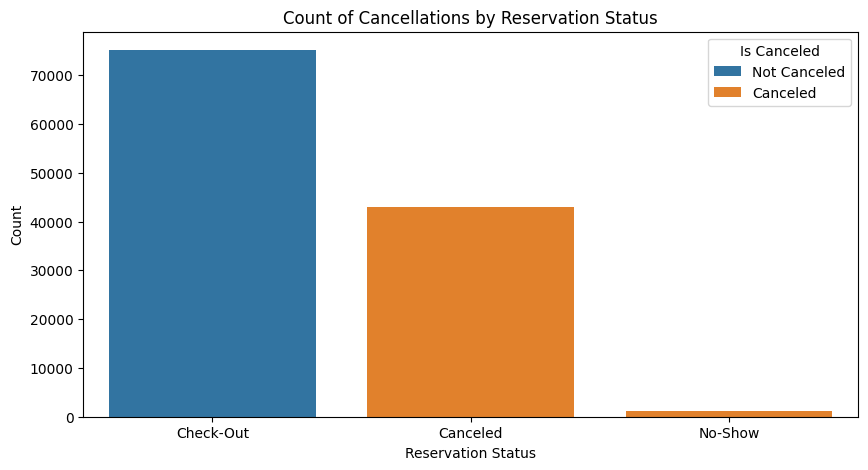

In [65]:
plt.figure(figsize=(10, 5))
sns.countplot(x='reservation_status', hue='is_canceled', data=df)
plt.title('Count of Cancellations by Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

- This feature is directly related to is_canceled so when it's canceled, it refers to 1 in is_canceled so it's should be dropped.

- Correlation between target

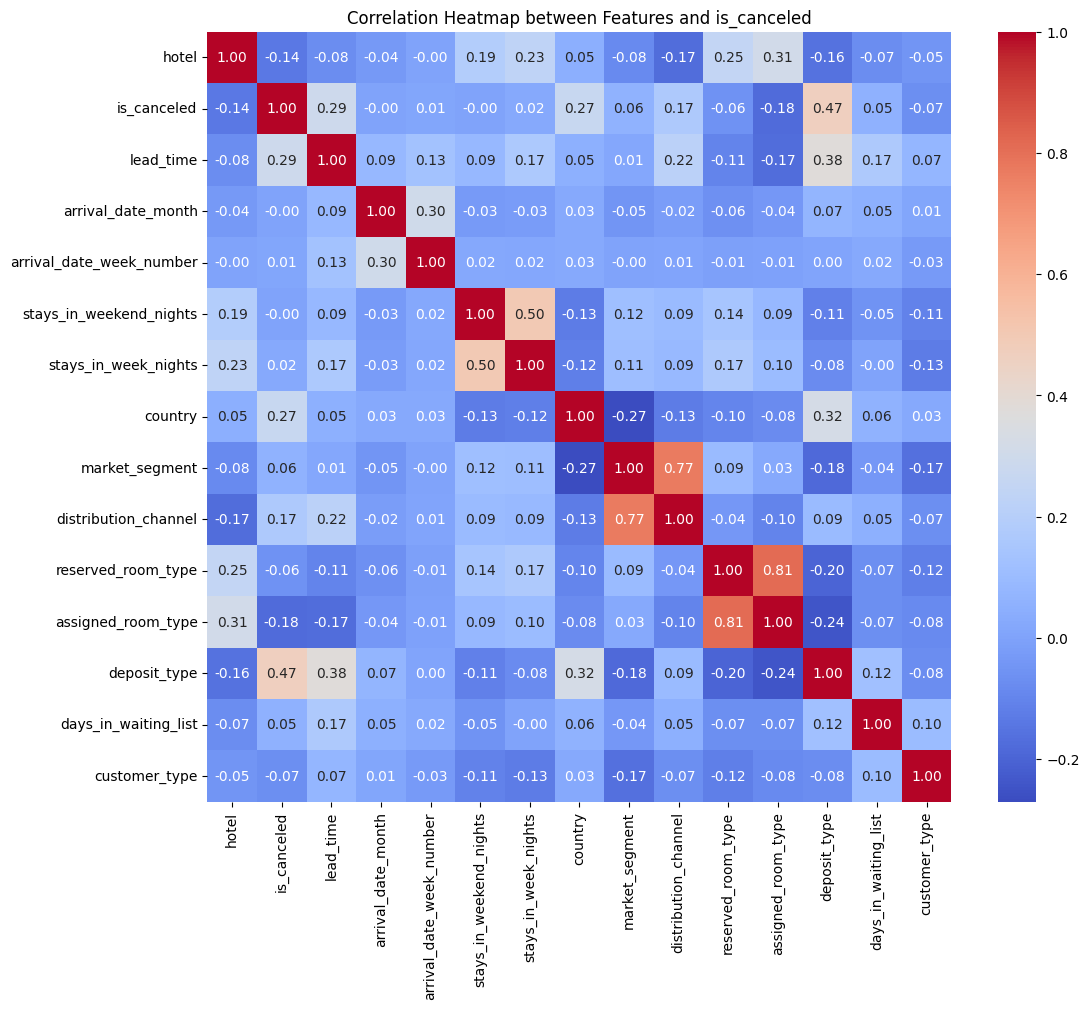

In [113]:
correlation_matrix = df1.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap between Features and is_canceled')
plt.show()

In [87]:
df1.drop(['adr','meal','children','adults','babies','is_repeated_guest','previous_cancellations',
          'previous_bookings_not_canceled','required_car_parking_spaces','total_of_special_requests'],axis=1,inplace=True)

In [88]:
df1.drop(['arrival_date_day_of_month','arrival_date_year','booking_changes', 'reservation_status', 'reservation_status_date'],axis=1,inplace=True)

### Splitting Data to Train, Validation and Test Subsets

In [89]:
X = df1.drop(['is_canceled'], axis=1, inplace=False)
y = df1['is_canceled']

# Divide data to train/validation/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

###  Feature Scaling & Normalization

In [90]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Training Classifiers

In [91]:
# Declare a dictionary to save (precision, recall, f1-score) for each classifier
classifiers = {
    'Logistic Regression': (0, 0, 0),
    'SVM': (0, 0, 0),
    'Decision Tree': (0, 0, 0),
    'K-NN': (0, 0, 0),
    'Gaussian NB': (0, 0, 0),
    'Random Forest': (0, 0, 0),
    'Decision Tree': (0, 0, 0),
    'XGBOOST': (0, 0, 0)
}

#### Logistic Regression

In [92]:
# Logistic Regression
clf_LR = LogisticRegression(max_iter=100)
clf_LR.fit(X_train, y_train)

y_pred = clf_LR.predict(X_val)
report = classification_report(y_val, y_pred, output_dict=True)['weighted avg']
classifiers['Logistic Regression'] = (report['precision'], report['recall'], report['f1-score'])

In [93]:
report

{'precision': 0.7646312436814391,
 'recall': 0.7554724145633237,
 'f1-score': 0.7363788742822726,
 'support': 17908.0}

#### SVM

In [94]:
# SVM
clf_SVM = SVC(kernel='rbf', C=2)
clf_SVM.fit(X_train, y_train)

y_pred = clf_SVM.predict(X_val)
report = classification_report(y_val, y_pred, output_dict=True)['weighted avg']
classifiers['SVM'] = (report['precision'], report['recall'], report['f1-score'])

#### Decision Tree

In [95]:
# Decision Tree
clf_DT = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf_DT.fit(X_train, y_train)

y_pred = clf_DT.predict(X_val)
report = classification_report(y_val, y_pred, output_dict=True)['weighted avg']
classifiers['Decision Tree'] = (report['precision'], report['recall'], report['f1-score'])

#### K-neighbors

In [ ]:
# KNN
trn_acc = []
val_acc = []
neighbours = range(1, 21)
for n in neighbours:
    clf_NN = KNeighborsClassifier(n_neighbors=n)
    clf_NN.fit(X_train, y_train)

    y_pred = clf_NN.predict(X_train)
    trn_acc.append(classification_report(y_train, y_pred, output_dict=True)['weighted avg']['f1-score'])

    y_pred = clf_NN.predict(X_val)
    val_acc.append(classification_report(y_val, y_pred, output_dict=True)['weighted avg']['f1-score'])

plt.title('Model Accuracy')
plt.plot(neighbours, trn_acc, label='f1-score: Train')
plt.plot(neighbours, val_acc, label='f1-score: Validation')
plt.legend(), plt.grid()
plt.xlabel('K'), plt.ylabel('f1-score')
plt.show()

In [96]:
# K = 3
clf_NN = KNeighborsClassifier(n_neighbors=3)
clf_NN.fit(X_train, y_train)

y_pred = clf_NN.predict(X_val)
report = classification_report(y_val, y_pred, output_dict=True)['weighted avg']
classifiers['K-NN'] = (report['precision'], report['recall'], report['f1-score'])

#### Gaussian Naive Bayes

In [97]:
clf_GNB = GaussianNB()
clf_GNB .fit(X_train,y_train)

y_pred = clf_GNB.predict(X_val)
report = classification_report(y_val,y_pred,output_dict=True)['weighted avg']
classifiers['Gaussian NB'] = (report['precision'], report['recall'], report['f1-score'])

#### Random Forest

In [98]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
classifier_rf.fit(X_train,y_train)

y_pred = classifier_rf.predict(X_val)
report = classification_report(y_val,y_pred,output_dict=True)['weighted avg']
classifiers['Random Forest'] = (report['precision'], report['recall'], report['f1-score'])

#### Decision Tree

In [99]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
classifier_dt.fit(X_train,y_train)

y_pred =classifier_dt.predict(X_val)
classification_report(y_val, y_pred, output_dict=True)['weighted avg']
report = classification_report(y_val, y_pred, output_dict=True)['weighted avg']
classifiers['Decision Tree'] = (report['precision'], report['recall'], report['f1-score'])

#### XGBOOST Classifier

In [100]:
 classifier_gb = XGBClassifier(objective= 'binary:logistic', random_state=0)
 classifier_gb.fit(X_train, y_train)

 y_pred = classifier_gb.predict(X_val)
 report = classification_report(y_val, y_pred, output_dict=True)['weighted avg']
 classifiers['XGBOOST'] = (report['precision'], report['recall'], report['f1-score'])

### Model Evaluation

Recap:
- Precision: measures how many of the predicted positive are positive (TP/TP+FP).
- Recall: measures the rate of true positive (TP/TP+FN).
- f1-score:  Combines the precision and recall of the model and it is defined as the harmonic mean of the model's precision and recall (recall * precision/recall + precision).
- ROC curves : A receiver operating characteristic (ROC) curve, is a graphical plot which illustrates the performance of a binary classification algorithm as a function of ture positive rate and false positive rate.

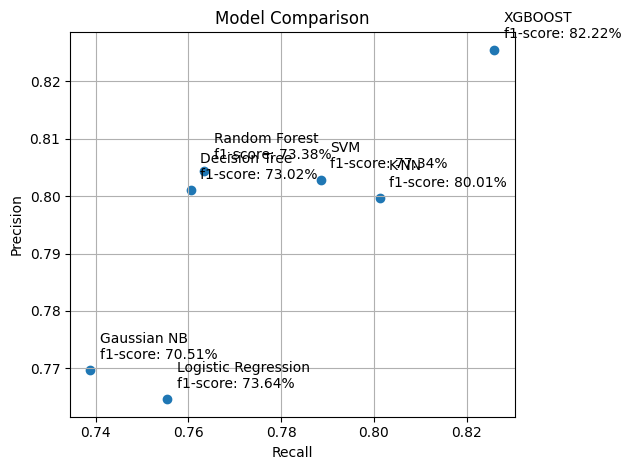

In [102]:
precision   = [classifiers[model][0] for model in classifiers.keys()]
recall = [classifiers[model][1] for model in classifiers.keys()]
f1_score = [classifiers[model][2] for model in classifiers.keys()]
annot        = [f'{clf}\nf1-score: {classifiers[clf][2]:.2%}' for clf in classifiers]

plt.title('Model Comparison')
plt.scatter(recall,precision)
# Add label to data points
margin = 0.002
for (x, y, t) in zip(recall, precision, annot):
    plt.text(x + margin, y + margin, t)

plt.xlabel('Recall'), plt.ylabel('Precision')
plt.grid()

plt.tight_layout()
plt.savefig('PR Chart.jpg', dpi=300)
plt.show()

In [101]:
# Create a DataFrame from the classifiers dictionary
model_df = pd.DataFrame.from_dict(classifiers, orient='index', columns=['Precision', 'Recall', 'F1-Score'])
model_df.sort_values(by='F1-Score', ascending=False, inplace=True)
model_df


,Precision,Recall,F1-Score
XGBOOST,0.825458,0.825944,0.822200
K-NN,0.799631,0.801206,0.800127
SVM,0.802821,0.788530,0.773403
Logistic Regression,0.764631,0.755472,0.736379
Random Forest,0.804444,0.763458,0.733803
Decision Tree,0.800985,0.760554,0.730237
Gaussian NB,0.769646,0.738888,0.705052


### Confusion Matrix of XGBOOST model

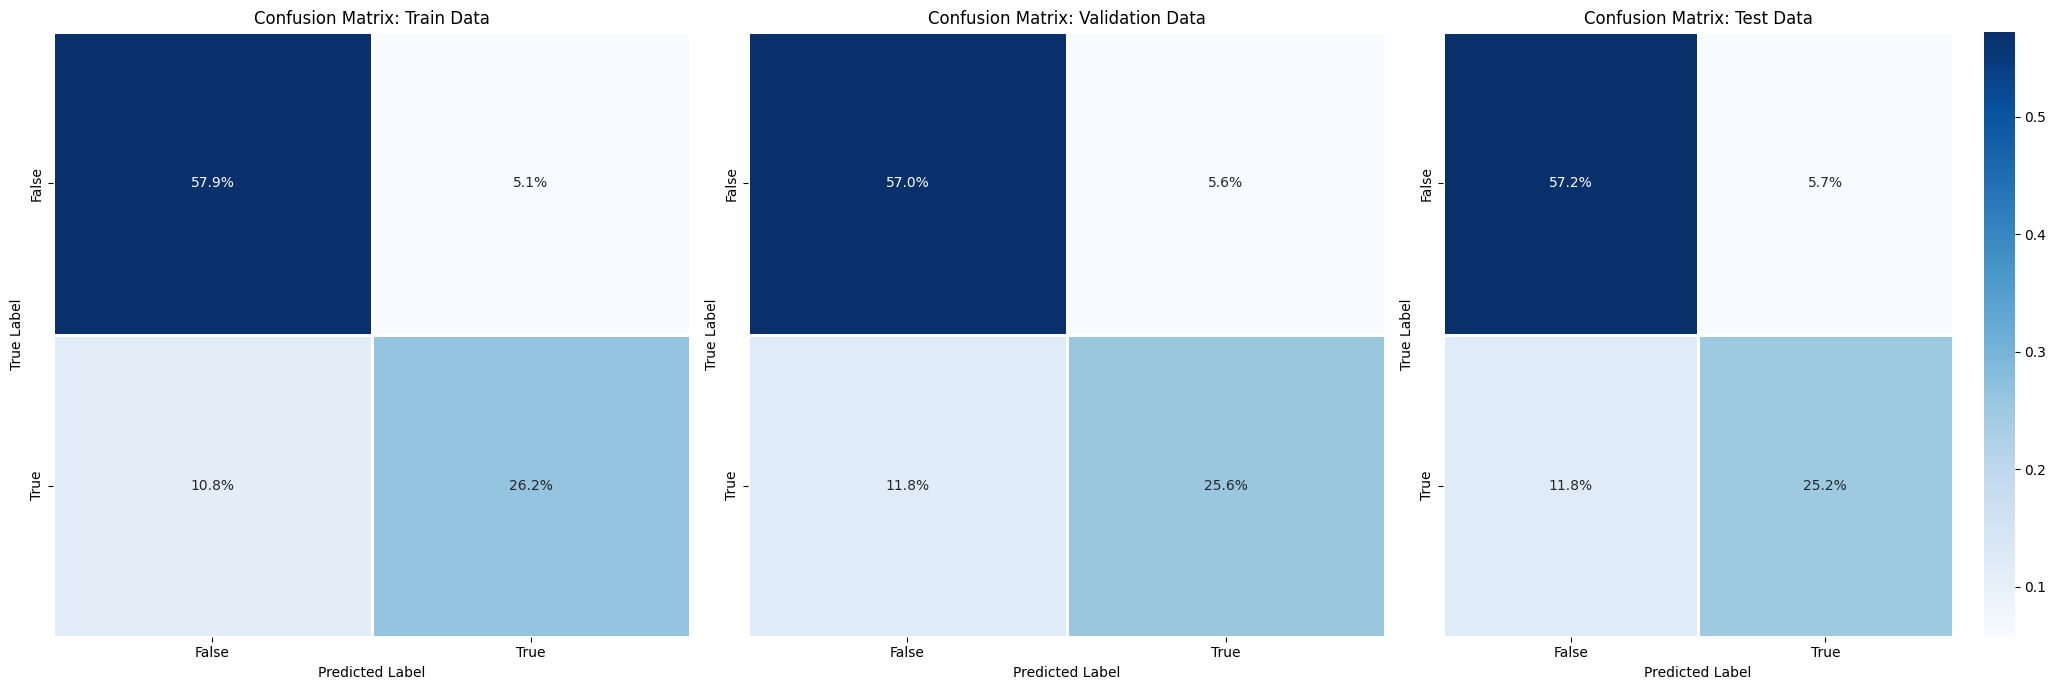

In [103]:
# Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.title('Confusion Matrix: Train Data')
y_pred =  classifier_gb.predict(X_train)
conf_mat = confusion_matrix(y_train, y_pred, normalize='all')
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='.1%',
    cmap="Blues",
    xticklabels=['False', 'True'], yticklabels=['False', 'True'],
    linewidths=2,
    linecolor='white',
    ax=axes[0],
    cbar=False,
)
plt.xlabel('Predicted Label'), plt.ylabel('True Label')


plt.subplot(1, 3, 2)
plt.title('Confusion Matrix: Validation Data')
y_pred =  classifier_gb.predict(X_val)
conf_mat = confusion_matrix(y_val, y_pred, normalize='all')
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='.1%',
    cmap="Blues",
    xticklabels=['False', 'True'], yticklabels=['False', 'True'],
    linewidths=2,
    linecolor='white',
    ax=axes[1],
    cbar=False,
)
plt.xlabel('Predicted Label'), plt.ylabel('True Label')


plt.subplot(1, 3, 3)
plt.title('Confusion Matrix: Test Data')
y_pred = classifier_gb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred, normalize='all')
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='.1%',
    cmap= "Blues",
    xticklabels=['False', 'True'], yticklabels=['False', 'True'],
    linewidths=2,
    linecolor='white',
    ax=axes[2],
    cbar=True,
)
plt.xlabel('Predicted Label'), plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('Confusion Matrix of XGboost classifier.jpg', dpi=300)
plt.show()

#### Final predictions

In [49]:
y_predict = classifier_gb.predict(X_test)
classification_report(y_test, y_predict, output_dict=True)['weighted avg']

{'precision': 0.8300099424983108,
 'recall': 0.8311463509967055,
 'f1-score': 0.8281512248915891,
 'support': 17909.0}

- The model has good performance and achieved an f1-score of 82.81%